### **Modeling the subsetted data**

In [8]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# NLP analysis imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# modeling imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from functions import model_scores # python file with a self-made function (saved in the 'code' folder)

---

In [4]:
# read the data without the combined_text column
data = pd.read_csv('../data/data_reddit.csv')

# remove all the posts with 'removed' text
data = data[data['selftext']!='[removed]']

# remove all the NAs in the selftext column
data.dropna(inplace=True)

# check the shape of the new, subsetted data frame
data.shape

(10046, 4)

In [5]:
# the variable is the column subreddit; 1 = datascience / 0 = books
data['y'] = data['subreddit'].map({'datascience':1, 'books':0})

In [6]:
# defining X and y
X = data['selftext']
y = data['y']

In [7]:
# baseline accuracy
y.value_counts(normalize=True) # baseline = 61%

1    0.610094
0    0.389906
Name: y, dtype: float64

---

### **1. TF-IDF Vectorizer - Logistic Regression**

In [9]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [10]:
count = 0 # count variable for specifying the model ID

model_params = {} # dictionary that will contain model parameters

In [16]:
## set modeling scaffolding ##

model_params = model_params # each time it's run, the model_params dict gets overwritten
count = count # overwriting count with each run

# defining a pipeline with 2 steps: CountVectorizer & LogisticRegression
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear'))
])

# set up the grid search parameters
params = {
    'tvec__max_features' : [6000],
    'tvec__min_df' : [2],
    'tvec__max_df' : [0.5],
    'tvec__ngram_range' : [(1,1)],
    'logreg__penalty' : ['l2'],
    'logreg__C' : [20]
}

# create grid search
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=6, verbose=1)

# fitting the model
gs.fit(X_train, y_train)

# increase the count variable
count += 1

# adding to our dictionary the best_params_ dictionary, in addition to the 'score'
gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_

# transform the params dictionary into a data frame, putting the model ID as the index
model_df = pd.DataFrame.from_dict(model_params, orient='index')

# print the data frame
model_df

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,logreg__C,logreg__penalty,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,score
model_1,1,l2,0.5,5000,2,"(1, 1)",0.971025
model_2,10,l2,0.5,6000,2,"(1, 1)",0.975780
model_3,10,l2,0.5,6000,3,"(1, 1)",0.975929
model_4,20,l2,0.5,6000,2,"(1, 1)",0.976077
model_5,20,l2,0.5,6000,2,"(1, 1)",0.976077


In [17]:
# instantiate vectorizer
tvec = TfidfVectorizer(max_df = 0.5, min_df=2, max_features=6000, ngram_range=(1,1))

# applying to the train data
X_train = tvec.fit_transform(X_train)

# applying to the test data
X_test = tvec.transform(X_test)

In [18]:
# instantiate model
logreg = LogisticRegression(solver='liblinear', penalty='l2', C=20)

# fit the model to the train data
logreg.fit(X_train, y_train)

LogisticRegression(C=20, solver='liblinear')

In [19]:
# training score
logreg.score(X_train, y_train)

0.9912332838038633

In [20]:
# testing score
logreg.score(X_test, y_test)

0.9737635705669482

In [21]:
# table of model scores
model_scores(X_test, y_test, logreg)

,score,value
0,accuracy,0.973764
1,missclassification,0.026236
2,specificity,0.941995
3,recall_sensitivity,0.994068
4,precision,0.964046
5,f1,0.978827


In [22]:
# save table into the folder model_scores_subset
df = model_scores(X_test, y_test, logreg)
df['vectorizer'] = 'TF-IDFVectorizer'
df['model'] = 'LogisticRegression'
df.to_csv('../model_scores/model_scores_subset/df_tvec_logreg.csv', index=False)

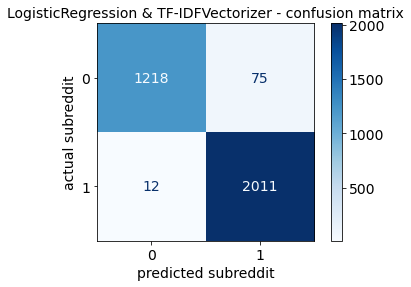

In [23]:
# plot and save confusion matrix
plt.rcParams.update({'font.size': 14});
plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', values_format='d');
plt.title('LogisticRegression & TF-IDFVectorizer - confusion matrix',fontsize=14);
plt.xlabel('predicted subreddit', fontsize=14);
plt.ylabel('actual subreddit', fontsize=14);
plt.savefig('../images/model_scores_subset/df_tvec_logreg.jpeg');

---

### **2. TF-IDF Vectorizer - Random Forest**

In [24]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [25]:
count = 0 # count variable for specifying the model ID

model_params = {} # dictionary that will contain model parameters

In [35]:
## set modeling scaffolding ##

model_params = model_params # each time it's run, the model_params dict gets overwritten
count = count # overwriting count with each run

# defining a pipeline with 2 steps: CountVectorizer & LogisticRegression
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])

# set up the grid search parameters
params = {
    'tvec__max_features' : [300],
    'tvec__min_df' : [7],
    'tvec__max_df' : [0.7],
    'tvec__ngram_range' : [(1,1)],
    'rf__n_estimators' : [200],
    'rf__max_depth' : [15],
    'rf__min_samples_split' : [2],
    'rf__ccp_alpha' : [0.01]
}

# create grid search
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=6, verbose=1)

# fitting the model
gs.fit(X_train, y_train)

# increase the count variable
count += 1

# adding to our dictionary the best_params_ dictionary, in addition to the 'score'
gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_

# transform the params dictionary into a data frame, putting the model ID as the index
model_df = pd.DataFrame.from_dict(model_params, orient='index')

# print the data frame
model_df

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,rf__ccp_alpha,rf__max_depth,rf__min_samples_split,rf__n_estimators,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,score
model_1,0.01,7,3,100,0.5,5000,5,"(1, 1)",0.890788
model_2,0.01,7,3,100,0.7,3000,7,"(1, 1)",0.916048
model_3,0.01,7,3,100,0.7,2000,7,"(1, 1)",0.930312
model_4,0.01,4,2,50,0.7,1000,7,"(1, 1)",0.903715
model_5,0.01,5,2,100,0.7,500,7,"(1, 1)",0.937593
model_6,0.01,5,2,120,0.7,300,7,"(1, 1)",0.942199
model_7,0.01,6,2,180,0.7,300,7,"(1, 1)",0.949629
model_8,0.01,8,2,200,0.7,300,7,"(1, 1)",0.954086
model_9,0.01,10,2,200,0.7,300,7,"(1, 1)",0.955275
model_10,0.01,15,2,200,0.7,300,7,"(1, 1)",0.955423


In [36]:
# instantiating vectorizer
tvec = TfidfVectorizer(max_df = 0.7, min_df=7, max_features=300, ngram_range=(1,1))

# applying to the train data
X_train = tvec.fit_transform(X_train)

# applying to the test data
X_test = tvec.transform(X_test)

In [37]:
# instantiate model - using best parameters
rf = RandomForestClassifier(random_state=42, ccp_alpha=0.01, max_depth=15, min_samples_split=2, 
                           n_estimators=200)

# fit the model to the train data
rf.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.01, max_depth=15, n_estimators=200,
                       random_state=42)

In [38]:
# training score
rf.score(X_train, y_train)

0.9548291233283804

In [39]:
# testing score
rf.score(X_test, y_test)

0.9574788902291917

In [40]:
# table of model scores
model_scores(X_test, y_test, rf)

,score,value
0,accuracy,0.957479
1,missclassification,0.042521
2,specificity,0.905646
3,recall_sensitivity,0.990608
4,precision,0.942615
5,f1,0.966016


In [41]:
# save table
df = model_scores(X_test, y_test, rf)
df['vectorizer'] = 'TF-IDFVectorizer'
df['model'] = 'RandomForest'
df.to_csv('../model_scores/model_scores_subset/df_tvec_rf.csv', index=False)

In [2]:
# plot and save confustion matrix
plt.rcParams.update({'font.size': 14});
plot_confusion_matrix(rf, X_test, y_test, cmap='Greens', values_format='d');
plt.title('RandomForest & TF-IDFVectorizer - confusion matrix',fontsize=14);
plt.xlabel('predicted subreddit', fontsize=14);
plt.ylabel('actual subreddit', fontsize=14);
plt.savefig('../images/model_scores_subset/df_tvec_rf.jpeg');

---

### **3. TF-IDF Vectorizer - Kernel Support Vector Classifier**

In [44]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [45]:
count = 0 # count variable for specifying the model ID

model_params = {} # dictionary that will contain model parameters

In [50]:
## set modeling scaffolding ##

model_params = model_params # each time it's run, the model_params dict gets overwritten
count = count # overwriting count with each run

# defining a pipeline with 2 steps: CountVectorizer & LogisticRegression
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
])

# set up the grid search parameters
params = {
    'tvec__max_features' : [3000],
    'tvec__min_df' : [5],
    'tvec__max_df' : [0.7],
    'tvec__ngram_range' : [(1,1)],
    'svc__C' : [1.5],
    'svc__kernel' : ['rbf'],
#     'svc__degree' : [2] # polynomial degrees to gridsearch over when trying out kernel = poly
}

# create grid search
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=6, verbose=1)

# fitting the model
gs.fit(X_train, y_train)

# increase the count variable
count += 1

# adding to our dictionary the best_params_ dictionary, in addition to the 'score'
gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_

# transform the params dictionary into a data frame, putting the model ID as the index
model_df = pd.DataFrame.from_dict(model_params, orient='index')

# print the data frame
model_df

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,svc__C,svc__degree,svc__kernel,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,score
model_1,0.5,2.0,rbf,0.7,400,6,"(1, 1)",0.962110
model_2,0.7,NaN,rbf,0.7,600,5,"(1, 1)",0.966122
model_3,0.8,NaN,rbf,0.7,1000,4,"(1, 1)",0.969242
model_4,1.2,NaN,rbf,0.7,3000,5,"(1, 1)",0.973403
model_5,1.5,NaN,rbf,0.7,3000,5,"(1, 1)",0.973551


In [51]:
# instantiate vectorizer
tvec = TfidfVectorizer(max_df = 0.7, min_df=5, max_features=3000, ngram_range=(1,1))

# applying to the train data
X_train = tvec.fit_transform(X_train)

# applying to the test data
X_test = tvec.transform(X_test)

In [52]:
# instantiate model
svc = SVC(random_state=42, C=1.5, kernel='rbf')

# fit the model to the train data
svc.fit(X_train, y_train)

SVC(C=1.5, random_state=42)

In [53]:
# training score
svc.score(X_train, y_train)

0.9915304606240714

In [54]:
# testing score
svc.score(X_test, y_test)

0.9719541616405307

In [55]:
# table of model scores
model_scores(X_test, y_test, svc)

,score,value
0,accuracy,0.971954
1,missclassification,0.028046
2,specificity,0.938902
3,recall_sensitivity,0.993080
4,precision,0.962165
5,f1,0.977378


In [56]:
# save table
df = model_scores(X_test, y_test, svc)
df['vectorizer'] = 'TF-IDFVectorizer'
df['model'] = 'KernelSupportVectorClassifier'
df.to_csv('../model_scores/model_scores_subset/df_tvec_svc.csv', index=False)

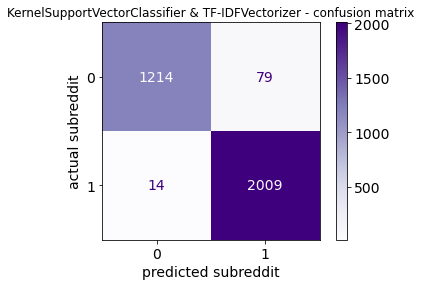

In [58]:
# plot and save confusion matrix
plt.rcParams.update({'font.size': 14});
plot_confusion_matrix(svc, X_test, y_test, cmap='Purples', values_format='d');
plt.title('KernelSupportVectorClassifier & TF-IDFVectorizer - confusion matrix',fontsize=12);
plt.xlabel('predicted subreddit', fontsize=14);
plt.ylabel('actual subreddit', fontsize=14);
plt.savefig('../images/model_scores_subset/df_tvec_svc.jpeg');

---

In [60]:
# put together all the model scores data frames
import os
import pandas as pd
files = os.listdir('../model_scores/model_scores_subset')

In [61]:
# check the first file
files

['.ipynb_checkpoints',
 'df_tvec_logreg.csv',
 'df_tvec_rf.csv',
 'df_tvec_svc.csv']

In [62]:
# exclude the first two files
files = files[1:]

In [63]:
# put the scores in the desired order
cols = ['accuracy', 'missclassification', 'recall_sensitivity', 'specificity', 'precision', 'f1']

# load the first file
model_info = pd.read_csv(f'../model_scores/model_scores_subset/{files[0]}')
# convert to wide format
model_info = model_info.pivot(index=['model','vectorizer'], columns='score', values='value')[cols]

# concatenate all data frames together
for file in range(1, len(files)):
    # load the next file in the line and convert to wide format
    df = pd.read_csv(f'../model_scores/model_scores_subset/{files[file]}')
    df = df.pivot(index=['model','vectorizer'], columns='score', values='value')[cols]
    # concatenate the data frames together
    model_info = pd.concat([model_info, df], axis=0)

In [64]:
model_info

,score,accuracy,missclassification,recall_sensitivity,specificity,precision,f1
model,vectorizer,,,,,,
LogisticRegression,TF-IDFVectorizer,0.973764,0.026236,0.994068,0.941995,0.964046,0.978827
RandomForest,TF-IDFVectorizer,0.957479,0.042521,0.990608,0.905646,0.942615,0.966016
KernelSupportVectorClassifier,TF-IDFVectorizer,0.971954,0.028046,0.993080,0.938902,0.962165,0.977378


In [65]:
# save the data frame with model info
model_info.to_csv('../data/model_info_summary_subset.csv')

---